# Study Case Forecasting Astra
Topik Zulkarnain
***

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

In [47]:
data = pd.read_csv('tute1.csv')

In [48]:
data.head()

,Unnamed: 0,Sales,AdBudget,GDP
0,Mar-81,1020.2,659.2,251.8
1,Jun-81,889.2,589.0,290.9
2,Sep-81,795.0,512.5,290.8
3,Dec-81,1003.9,614.1,292.4
4,Mar-82,1057.7,647.2,279.1


In [49]:
#Mengganti Nama Feature Unnamed : 0
data.rename(columns={'Unnamed: 0' : 'Date'}, inplace = True)

In [50]:
#Membuat format feature Date 
year = []
month = []
for i in data['Date']:
    y = i.split('-')[1]
    
    month.append(i.split('-')[0])
    if y[0]!='0':
        year.append('19'+y)
    else :
        year.append('20'+y)

In [51]:
data['Date'] = pd.to_datetime(['{}-{}-01'.format(y,m) for y, m in zip(year,month)])

In [52]:
#Pada kasus ini hanya akan digunakan data Date dan Sales, oleh karena itu akan di drop data AdBudget dan GDP
data = data.drop(columns = ['AdBudget', 'GDP'])

In [53]:
data.head()

,Date,Sales
0,1981-03-01,1020.2
1,1981-06-01,889.2
2,1981-09-01,795.0
3,1981-12-01,1003.9
4,1982-03-01,1057.7


In [54]:
#Membuat date menjadi index data
indexedDataset = data.set_index('Date')
indexedDataset.head()

,Sales
Date,
1981-03-01,1020.2
1981-06-01,889.2
1981-09-01,795.0
1981-12-01,1003.9
1982-03-01,1057.7


# Visualisasi Pola Data

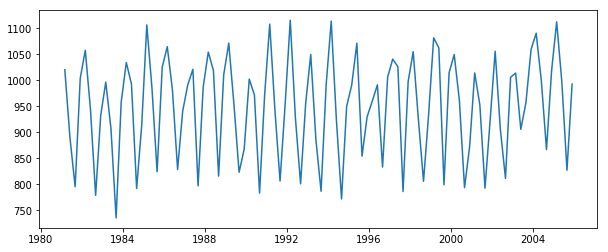

In [55]:
plt.figure(figsize = (10,4))
plt.plot(indexedDataset)

Berdasarkan pola data time series dapat dilihat bahwa ragam pada data sales sudah stationer, namun rataan data masih belum stasioner. Oleh karena itu, pada kasus ini tidak diperlukan transformasi data.

In [56]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['Sales'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)' %key] = value
  
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -3.262755
p-value                         0.016628
#Lags Used                      9.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [57]:
#Determing rolling statistics
rolmean = indexedDataset.rolling(window=4).mean()

rolstd = indexedDataset.rolling(window=4).std()

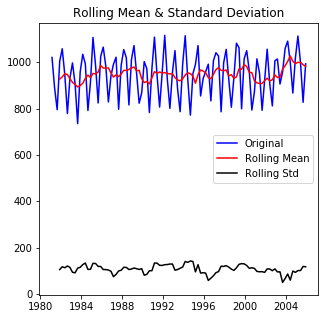

In [58]:
#Plot rolling statistics:
plt.figure(figsize=(5,5))
orig = plt.plot(indexedDataset, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

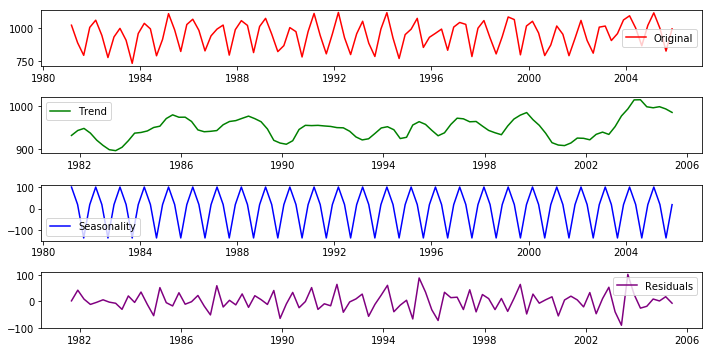

In [59]:
#Membandingkan Data Asli terhadap Trend, Seasonal, dan Residual nya
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize = (10,5))
plt.subplot(411)
plt.plot(indexedDataset, label='Original', color = 'red')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color = 'green')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color = 'blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color = 'purple')
plt.legend(loc='best')
plt.tight_layout()


## Visualisasi Plot Autocorrelation dan Plot Partial Auto Correlation Untuk Menentukan Model ARIMA

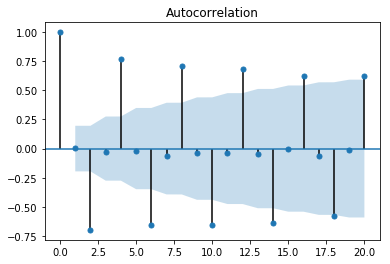

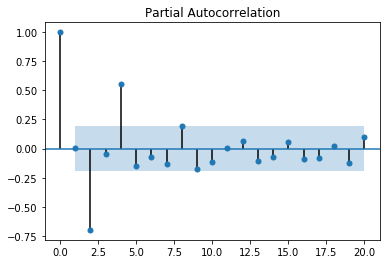

In [60]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

lag_acf = acf(indexedDataset, nlags=20)
lag_pacf = pacf(indexedDataset, nlags=20, method='ols')
plt.figure(figsize=(10,6))
plot_acf(indexedDataset, lags=20)
pyplot.show()
plot_pacf(indexedDataset, lags=20)
pyplot.show()


Dari Plot ACF terlihat bahwa data berpola musiman periode 2 dan plot PACF signifikan pada 4 lag, oleh karena itu model awal yang dapat dicoba adalah
ARIMA(4,0,0) dan model SARIMA(4,0,0)[2]

C:\Users\topikz064115\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\topikz064115\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\topikz064115\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtyp

Plotting AR model


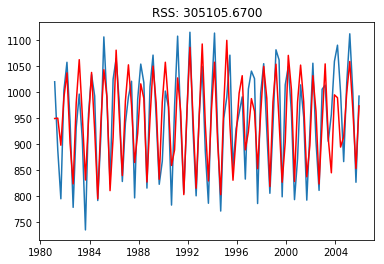

In [82]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(indexedDataset, order=(4,0,0))
results_AR = model.fit(disp=-1)
plt.plot(indexedDataset)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-indexedDataset.Sales)**2))
print('Plotting AR model')

C:\Users\topikz064115\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


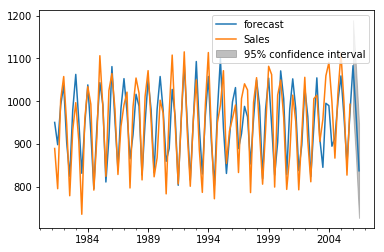

In [83]:
results_AR.plot_predict(1,102)
x=results_AR.forecast(steps=120)

In [63]:
from sklearn.metrics import mean_absolute_error

In [81]:
mean_absolute_error(indexedDataset.Sales,results_AR.fittedvalues)

38.276278383194516

Plotting SARIMA model


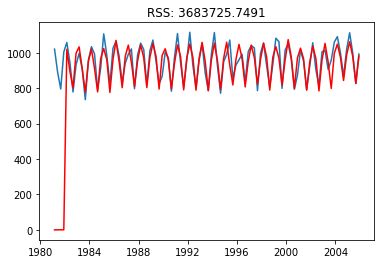

In [88]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#SARIMA MODEL
model = SARIMAX(indexedDataset, order=(4,0,0), seasonal_order = (1,1,1,4))
results_SARIMAX = model.fit(disp=-1)
plt.plot(indexedDataset)
plt.plot(results_SARIMAX.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_SARIMAX.fittedvalues-indexedDataset.Sales)**2))
print('Plotting SARIMA model')

In [85]:
results_SARIMAX.plot_predict(1,102)
x=results_SARIMAX.forecast(steps=120)

AttributeError: 'SARIMAXResults' object has no attribute 'plot_predict'

In [90]:
mean_absolute_error(indexedDataset.Sales, results_SARIMAX.fittedvalues)

72.93867598152008